In [1]:
%cd ..
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # use cpu because I'm training on gpu

from thumbs.experiments.pokemon_big_both import PokemonExperiment
# from thumbs.experiments.pokemon_wgan_5stride_good_dataset import PokemonExperiment
from thumbs.train import load_weights
from thumbs.viz import show_samples, visualize_preprocessed_image
import tensorflow as  tf
import numpy as np



/home/anthony/workspace/yt-data


/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exp = PokemonExperiment()
mparams = exp.get_mutable_params()
m = exp.get_model(mparams[0]).build()
load_weights(m.gan, exp.get_params().weight_path)

2023-06-28 15:24:18.790256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "discriminator"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                             Output Shape                                                                    Param #                       
 conv2d (Conv2D)                                                                          (None, 32, 32, 64)                                                              4864                          
                                                                                                                                                                                                        
 leaky_re_lu (LeakyReLU)                                                                  (None, 32, 32, 64)                                                              0  

# Make a fake pokemon and judge it

<Figure size 640x480 with 0 Axes>

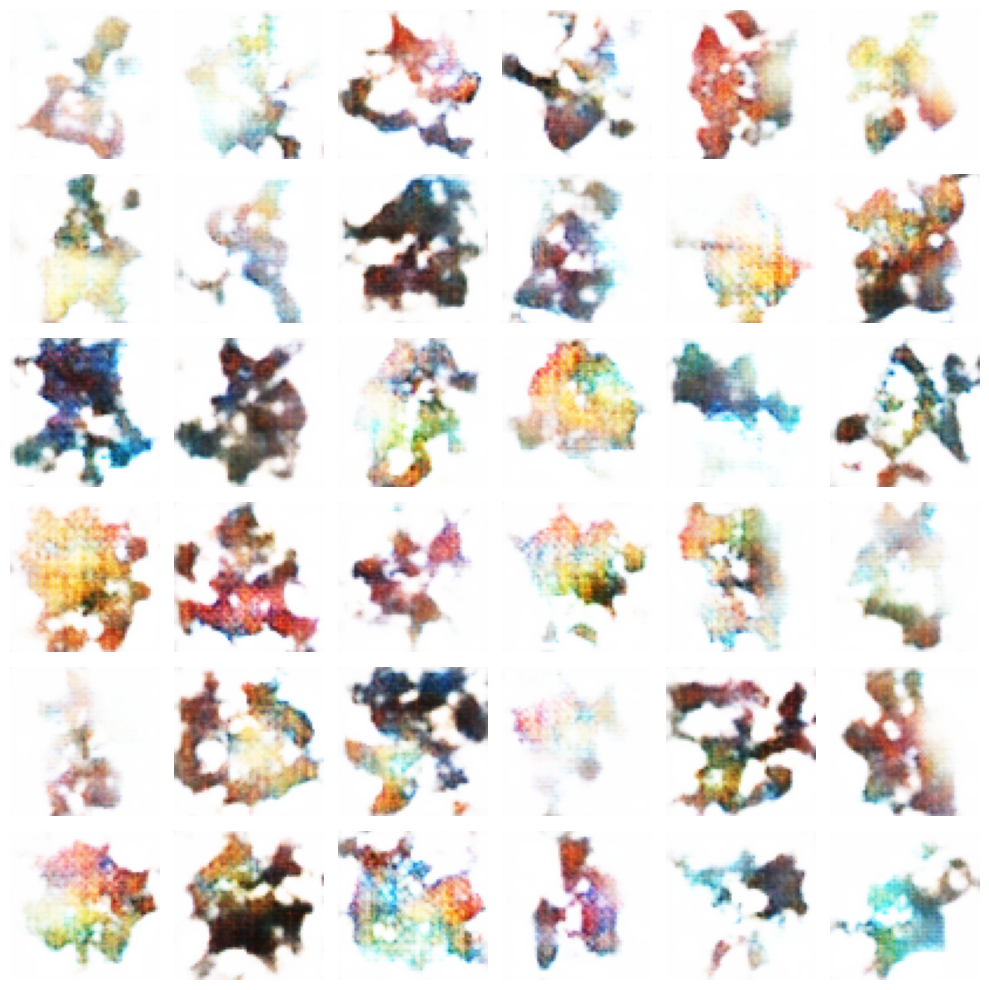

In [3]:
show_samples(m.generator, exp.get_params().latent_dim, rows=6, cols=6, file_name="tmp.jpg", dir="/tmp")

1/1 [==============================] - 0s 29ms/step


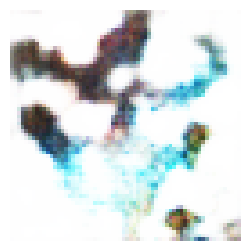

1/1 [==============================] - 0s 53ms/step
[[51.633015]]


In [4]:

noise = np.random.normal(0, 1, (1, 100))
generated_thumbnails = m.generator.predict(noise)
visualize_preprocessed_image(generated_thumbnails[0], (3,3))
print(m.discriminator.predict(generated_thumbnails))


In [5]:
# mean of a lot of generated images
noise = np.random.normal(0, 1, (800, 100))
generated_thumbnails = m.generator.predict(noise)
print(np.mean(m.discriminator.predict(generated_thumbnails)))

25/25 [==============================] - 1s 29ms/step
51.64097


# Judge a real pokemon

Images in /home/anthony/workspace/yt-data/data/pokemon
['282-mega.jpg', '582.jpg', '340.jpg', '570.jpg', '136.jpg', '531-mega.jpg', '335.jpg', '96.jpg', '581.jpg', '153.jpg']
Found 819 total files
Found 819 jpgs


100%|██████████| 819/819 [00:00<00:00, 1138.72it/s]


<Figure size 640x480 with 0 Axes>

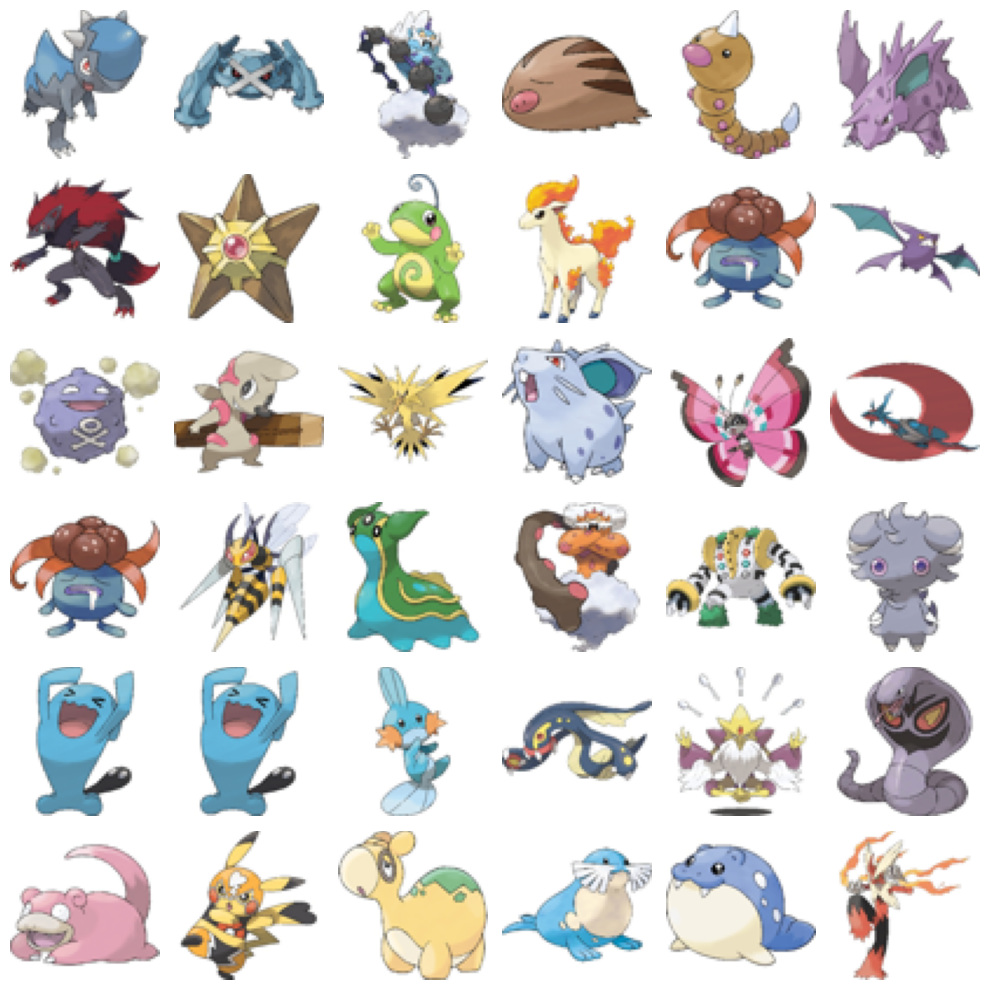

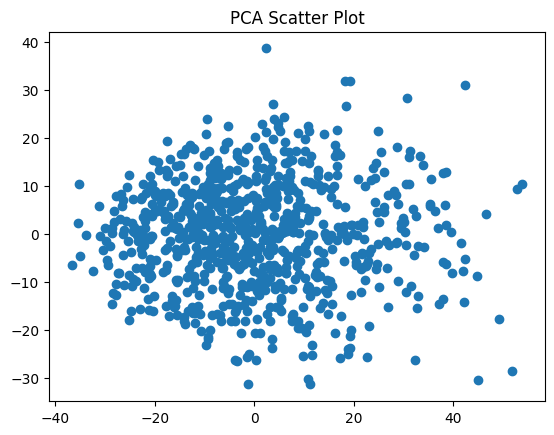

(819, 64, 64, 3)

In [9]:
from thumbs.data import get_pokemon_data256
images = get_pokemon_data256(exp.get_params().img_shape)
images.shape

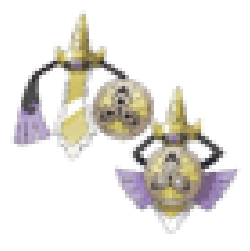

1/1 [==============================] - 0s 21ms/step
[[51.13286]]


In [10]:
real_pokemon = images[np.random.randint(0, images.shape[0], 1)]
visualize_preprocessed_image(real_pokemon[0], (3,3))

print(m.discriminator.predict(real_pokemon))



In [11]:

# Mean of the entire real set
print(np.mean(m.discriminator.predict(images)))

26/26 [==============================] - 1s 24ms/step
55.737057


# Inspect hidden layer output

Layer 1 of 5, shape (None, 8, 8, 256), name conv2d_transpose/BiasAdd:0


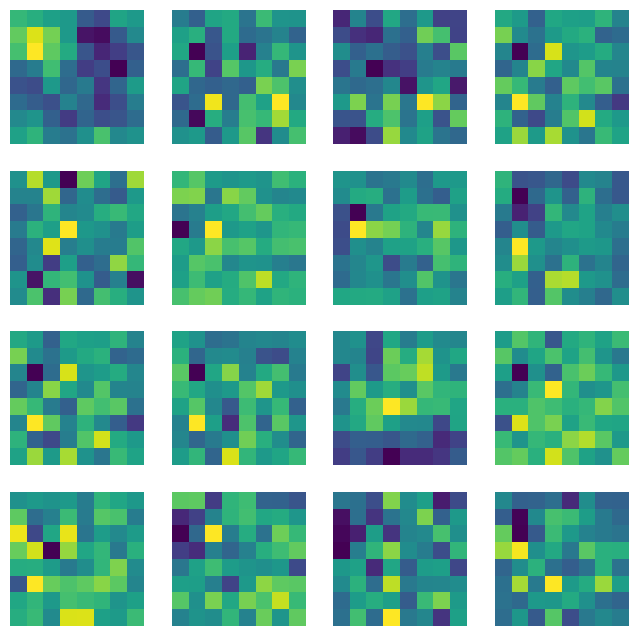

Layer 2 of 5, shape (None, 16, 16, 128), name conv2d_transpose_1/BiasAdd:0


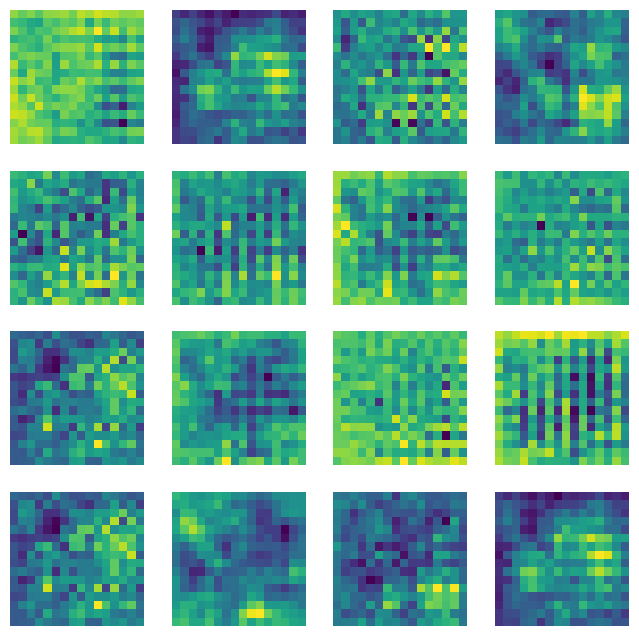

Layer 3 of 5, shape (None, 32, 32, 64), name conv2d_transpose_2/BiasAdd:0


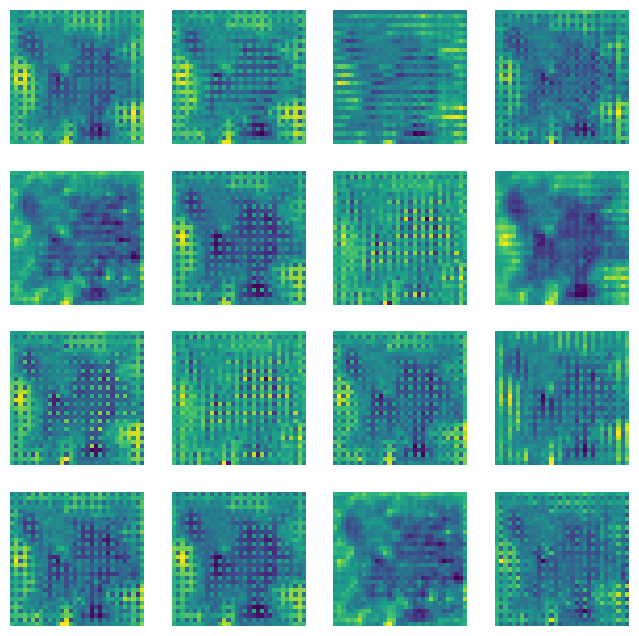

Layer 4 of 5, shape (None, 64, 64, 3), name conv2d_transpose_3/BiasAdd:0


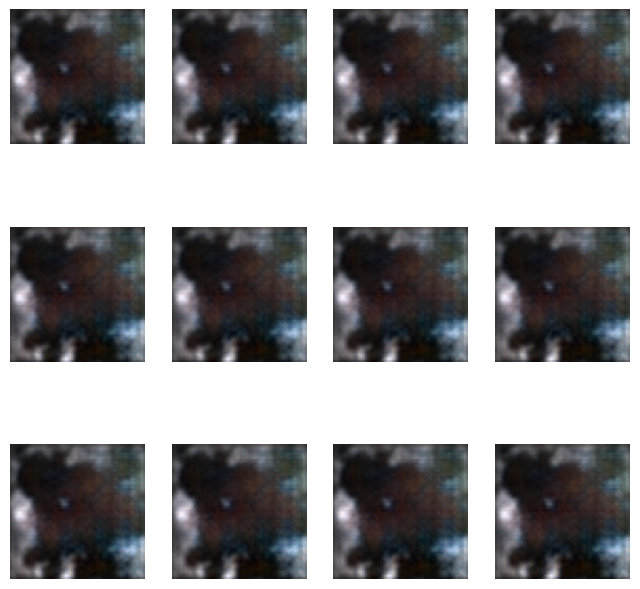

Layer 5 of 5, shape (None, 64, 64, 3), name activation/Tanh:0


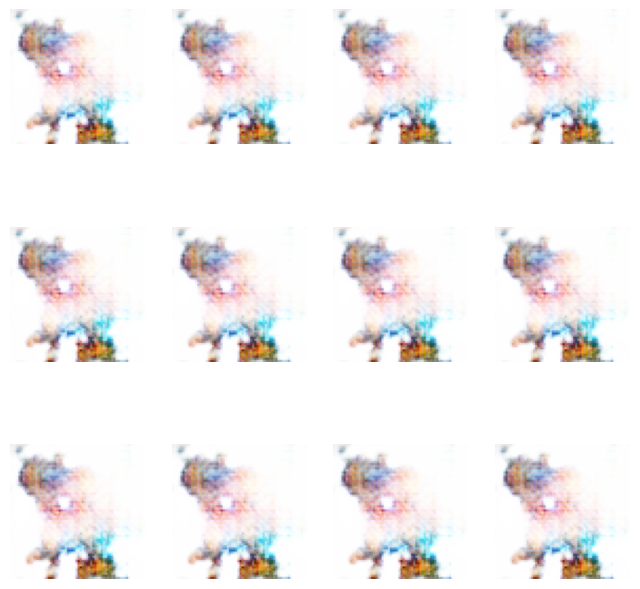

In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def get_intermediate_models(model):
    intermediate_models = []
    # layers_to_get = [2,5,8,11, 12]
    for i in range(len(model.layers)):
        # only pick models that have conv2d_transpose_1 or tanh in the name
        if 'conv2d_transpose' in model.layers[i].output.name.lower() or 'tanh' in model.layers[i].output.name.lower():
            print(model.layers[i])
            intermediate_model = Model(inputs=model.input, outputs=model.layers[i].output)
            intermediate_models.append(intermediate_model)
    return intermediate_models


generator = m.generator
intermediate_models = get_intermediate_models(generator)
noise = np.random.normal(0, 1, (1, 100))
for i, intermediate_model in enumerate(intermediate_models):
    print(f'Layer {i+1} of {len(intermediate_models)}, shape {intermediate_model.output_shape}, name {intermediate_model.output.name}')
    intermediate_output = intermediate_model.predict(noise, verbose=0)

    intermediate_output = intermediate_output[0]
    # n = 64
    # intermediate_output = intermediate_output[:, :, :n]

    intermediate_output -= intermediate_output.min() # Make the minimum 0
    intermediate_output /= intermediate_output.max() # Make the maximum 1

    n_cols = 4
    n_channels = min(n_cols, intermediate_output.shape[2])
    fig, axs = plt.subplots(n_channels , n_cols, figsize=(8, 8))
    for i in range(n_channels):
        for j in range(n_cols):
            if n_channels == 3:
                axs[i][j].imshow(intermediate_output)
            else:
                axs[i][j].imshow(intermediate_output[:, :, np.random.randint(0, intermediate_output.shape[2])])
            axs[i][j].axis('off')

    plt.show()

